In [43]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
import torch.nn.functional as F


if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU на Mac (Apple Silicon або AMD)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (не на Mac)
    print(
        f"GPU count: {torch.cuda.device_count()}"
        f", CUDA version: {torch.version.cuda}"
        f", cuDNN version: {torch.backends.cudnn.version()}"
    )
else:
    device = torch.device("cpu")  # fallback

print("Using GPU:", device)

GPU count: 1, CUDA version: 12.8, cuDNN version: 91002
Using GPU: cuda


In [44]:
PATH = "./CIFAR100.pth"

batch_size = 128
features = 100
num_workers = 8 if device.type == "cuda" else 0

learning_rate = 1e-3
weight_decay = 1e-4

max_epochs = 100

In [45]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

train_dataset = torchvision.datasets.CIFAR100(
    root="./cifar100", download=True, transform=transform, train=True
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./cifar100", download=True, transform=transform_test, train=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


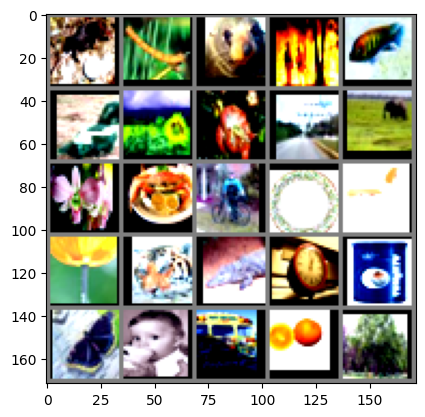

In [46]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=num_workers
)


def showimg(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
showimg(img_grid)

In [47]:
class Cifar100Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )
        self.aap2 = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Sequential(
            nn.Linear(128, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 100)
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.aap2(out)
        out = torch.flatten(out, 1)
        out = self.lin(out)
        return out

In [48]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, features),
        )

    def forward(self, x):
        out = self.conv_l1(x)
        out = self.conv_l2(out)
        out = self.conv_l3(out)
        out = self.conv_l4(out)
        out = self.conv_l5(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [49]:
train_losses, train_accuracies = [], []

model = VGG16()
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

linearLR = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)

cosine_annealingLR = CosineAnnealingLR(optimizer, T_max=max_epochs)

scheduler = SequentialLR(
    optimizer, [linearLR, cosine_annealingLR], milestones=[5]
)

n_total_steps = len(train_loader)

for epoch in range(max_epochs):
    train_loss, correct_train = 0, 0
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss_value = criterion(outputs, labels)
        loss_value.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss_value
        train_loss += loss_value.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / len(train_dataset))

    scheduler.step()
    print(f"[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}")

print("Training finished")
torch.save(model.state_dict(), PATH)

[1] loss: 4.307
[2] loss: 3.958
[3] loss: 3.633
[4] loss: 3.354
[5] loss: 3.162
[6] loss: 3.036
[7] loss: 2.868
[8] loss: 2.736
[9] loss: 2.630
[10] loss: 2.534
[11] loss: 2.455
[12] loss: 2.379
[13] loss: 2.318
[14] loss: 2.272
[15] loss: 2.207
[16] loss: 2.159
[17] loss: 2.109
[18] loss: 2.058
[19] loss: 2.015
[20] loss: 1.987
[21] loss: 1.939
[22] loss: 1.906
[23] loss: 1.863
[24] loss: 1.832
[25] loss: 1.805
[26] loss: 1.773
[27] loss: 1.742
[28] loss: 1.707
[29] loss: 1.679
[30] loss: 1.650
[31] loss: 1.628
[32] loss: 1.597
[33] loss: 1.570
[34] loss: 1.559
[35] loss: 1.526
[36] loss: 1.503
[37] loss: 1.473
[38] loss: 1.454
[39] loss: 1.433
[40] loss: 1.415
[41] loss: 1.383
[42] loss: 1.370
[43] loss: 1.354
[44] loss: 1.336
[45] loss: 1.314
[46] loss: 1.291
[47] loss: 1.272
[48] loss: 1.265
[49] loss: 1.242
[50] loss: 1.226
[51] loss: 1.206
[52] loss: 1.190
[53] loss: 1.175
[54] loss: 1.159
[55] loss: 1.144
[56] loss: 1.135
[57] loss: 1.120
[58] loss: 1.101
[59] loss: 1.092
[60] l

In [50]:
load_model = VGG16()
load_model.to(device)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = load_model(images)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f"Accuracy of the network on the {n_samples} test image: {100*acc}%")

Accuracy of the network on the 10000 test image: 68.93%


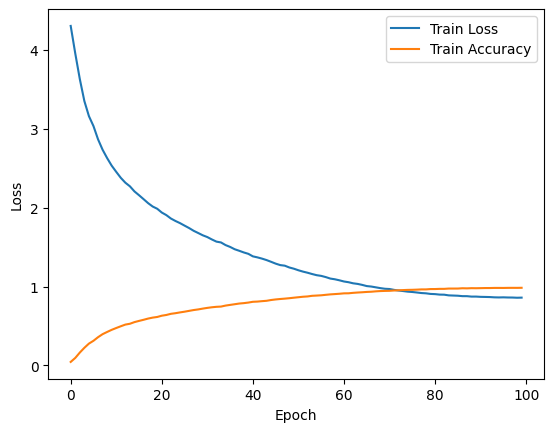

In [51]:
plt.plot(train_losses, label="Train Loss")
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()